# Исследование о сервисе аренды самокатов

Сервис аренды самокатов GoFast предоставил данные о поездках пользователей из нескольких городов. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться с подпиской и без нее. Необходимо проанализировать данные и проверить гипотезы, которые могут помочь бизнесу вырасти:
- пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки;
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Цель исследования:** провести сравнение поведения пользователей сервиса аренды самокатов с подпиской и без для помощи в определении дальнейших стратегий развития сервиса. 

**Задачи исследования:** 

- определить пригодность исходных данных для дальнейшего анализа, провести предобработку данных;
- выявить наиболее частотные значения таких характеристик пользователей как город проживания, наличие подписки, возраст, расстояние и продолжительность поездок.
- сравнить характеристики пользователей с подпиской и без;
- проверить гипотезы о сходстве поведения пользователей с подпиской и без нее.

## Краткие выводы по результатам анализа

По результатам анализа данных:

- данные одинаково репрезентативны для всех 8 городов, где действует сервис;
- самое большое количество пользователей в Пятигорске, самое маленькое – в Москве;
- количество пользователей без подписки превышает количество пользователей с подпиской на 19% (835 против 699);
- наиболее часто встречающийся возраст пользователей - 22-28 лет;
- выявлены две стратегии пользования самокатом: на малых расстояниях (пиковое значение – 750 метров), на больших расстояниях (пиковое значение – 3000 метров) (данные могут быть использованы для корректировки тарифных планов);
- наиболее частая продолжительность поездок - 12-22 минут;
- выявлен пик поездок продролжительностью 0.5 минуты при значительном преодолеваемом расстоянии. Он характерен только для пользователей без подписки. Возможно речь идет о технической неисправности в работе приложения.

По результатам проверки гипотез:
- С наибольшей долей вероятности, пользователи с подпиской потратят больше времени на поездки, чем пользователи без подписки, а также принесут большую выручку.
- С вероятностью 33% среднее значение, проезжаемое пользователем с подпиской, будет равно 3130 метрам.

## Обзор данных

Импортируем необходимые для проведения анализа данных библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from scipy import stats as st
from math import factorial
from scipy.special import comb
import pylab as pl
import json
from IPython.display import display, HTML

Прочитаем файлы `users_go.csv`, `subscriptions_go.csv` и `rides_go.csv` с данными (путь к данным храниться в файлах формата json) и сохраним их в соответствующих переменных `users`, `subscriptions`, `rides`:

In [2]:
# Чтение JSON файла
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Чтение данных 
dataset_path_users = config['dataset_path_users_go']
dataset_path_subscriptions = config['dataset_path_subscriptions_go']
dataset_path_rides = config['dataset_path_rides_go']
users = pd.read_csv(dataset_path_users)
subscriptions = pd.read_csv(dataset_path_subscriptions)
rides = pd.read_csv(dataset_path_rides)

Уберем ограничения при отображении количества столбцов, строк, ширины столбцов.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Выведем первые строки каждого набора данных и общую информацию о каждом датафрейме.

In [4]:
# Функция для вывода первых 10 строк и информации о датафрейме
def display_data(df, df_name):
    print(f"Первые 10 строк датафрейма {df_name}:\n")
    print(df.head(10))
    print("\nИнформация о датафрейме:\n")
    print(df.info())
    print("\n" + "="*80 + "\n")

# Основная функция для вывода данных для 'users', 'subscriptions' и 'rides'
def main():
    display_data(users, 'users')
    display_data(subscriptions, 'subscriptions')
    display_data(rides, 'rides')

# Запускаем основную функцию
main()

Первые 10 строк датафрейма users:

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
5        6      Регина   25       Краснодар             ultra
6        7       Игорь   23            Омск             ultra
7        8        Юрий   23       Краснодар             ultra
8        9          Ян   21       Пятигорск             ultra
9       10     Валерий   18    Екатеринбург             ultra

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name

По начальным строкам каждого из датафреймов можно сделать вывод о том, что они содержат релевантные данные. Во всех датафреймах отсутствуют пропущенные значения. 

## Предобработка данных

Тип данных в столбце `date` датафрйема `rides` - `object`. Перезапишем значения в формате `datetime`:

In [5]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Создадим новый столбец с номером месяца на основе столбца `date`:

In [6]:
rides['month'] = rides['date'].dt.month

Дополнительно проверим наличие пропущенных значений в датафреймах `users` и `rides` методом `isna()`:

In [7]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [8]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропущенные значения во всех датафрйемах отсутствуют. Проверим наличие явных дубликатов в датафреймах:

In [9]:
users.duplicated().sum()

31

In [10]:
rides.duplicated().sum()

0

Удалим явные дубликаты из датафрйема `users`, перезапишем индексы данного датафрейма:

In [11]:
users = users.drop_duplicates().reset_index()

Проверим отсутствие опечаток в наименованиях городов:

In [12]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Можно сделать вывод о том, что во всех датафреймах представлены полные данные, явные дубликаты были удалены, неявные дубликаты отсутствуют. 

## Исследовательский анализ данных

### Распределение пользователей по городам

Определим, в каком городе наибольшее количество пользователей, а также визуализируем полученную информацию:

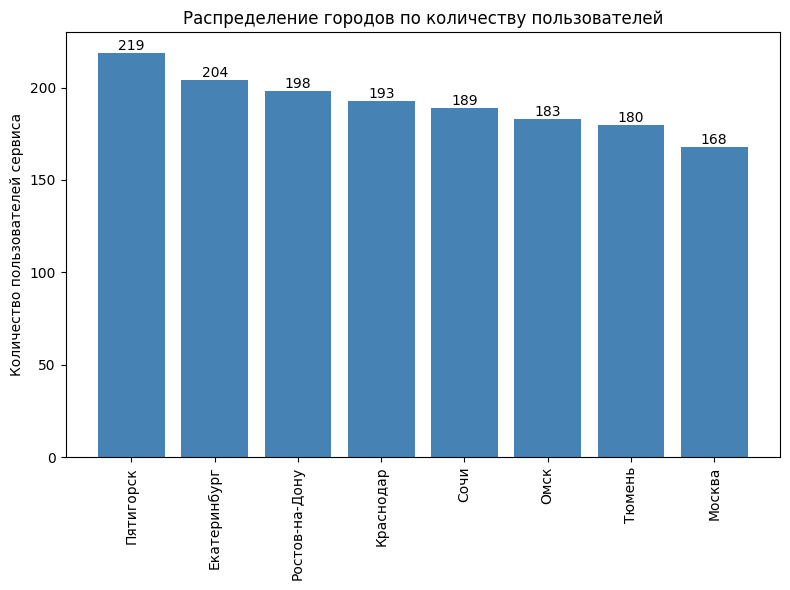

In [13]:
# Создаем столбчатую диаграмму
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Получаем текущие оси
bars = ax.bar(users['city'].value_counts().index, 
              users['city'].value_counts().values, 
              color='steelblue')

ax.set_ylabel('Количество пользователей сервиса')
ax.set_title('Распределение городов по количеству пользователей')
ax.set_xticks(range(len(users['city'].value_counts().index)))
ax.set_xticklabels(users['city'].value_counts().index, rotation=90)

# Добавляем подписи столбцов
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.0f}', 
            ha='center', 
            va='bottom')

# Показываем график
plt.tight_layout()
plt.show()

Распределение городов по количеству пользователей сервиса в датафрейме весьма равномерно, без пиковых значений. Всего в датафрейм попали данные о 8 городах, где был запущен сервис. Наибольшее количество пользователей в Пятигорске, наименьшее - в Москве. 

### Соотношение пользователей с подпиской и без подписки

Определим соотношение пользователей с подпиской и без подписки и визуализируем полученные данные:

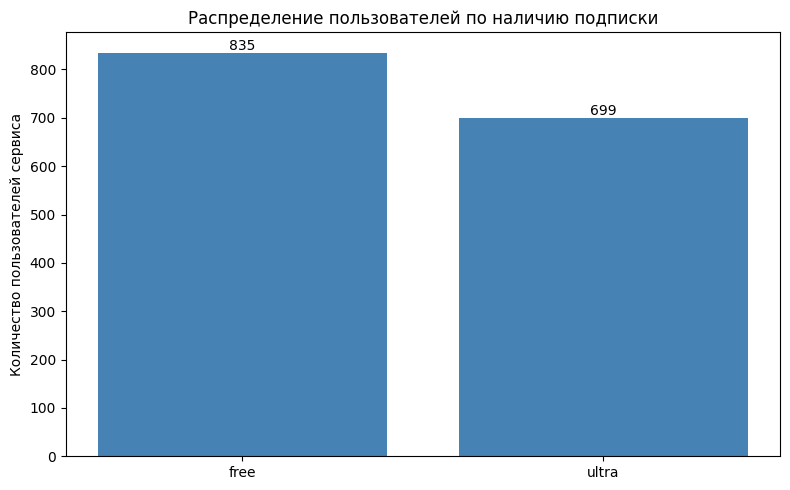

In [14]:
# Создаем столбчатую диаграмму
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Получаем текущие оси
bars = ax.bar(sorted(users['subscription_type'].unique()), 
              users['subscription_type'].value_counts(), 
              color='steelblue')

ax.set_ylabel('Количество пользователей сервиса')
ax.set_title('Распределение пользователей по наличию подписки')
ax.set_xticks(range(len(users['subscription_type'].value_counts().index)))
ax.set_xticklabels(users['subscription_type'].value_counts().index, rotation=0)

# Добавляем подписи столбцов
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.0f}', 
            ha='center', 
            va='bottom')

# Показываем график
plt.tight_layout()
plt.show()

Выведем соотношение пользователей с подпиской и без нее:

In [15]:
subsc_ratio = users.loc[users['subscription_type'] == 'free']['subscription_type'].count()/\
              users.loc[users['subscription_type'] == 'ultra']['subscription_type'].count()
subsc_ratio.round(2)

1.19

Количество пользователей без подписки превышает количество пользователей с подпиской на 19% (835 пользователей без подписки против 699 с подпиской).

### Возраст пользователей

Определим количество пользователей каждого возраста и визуализируем полученные данные:

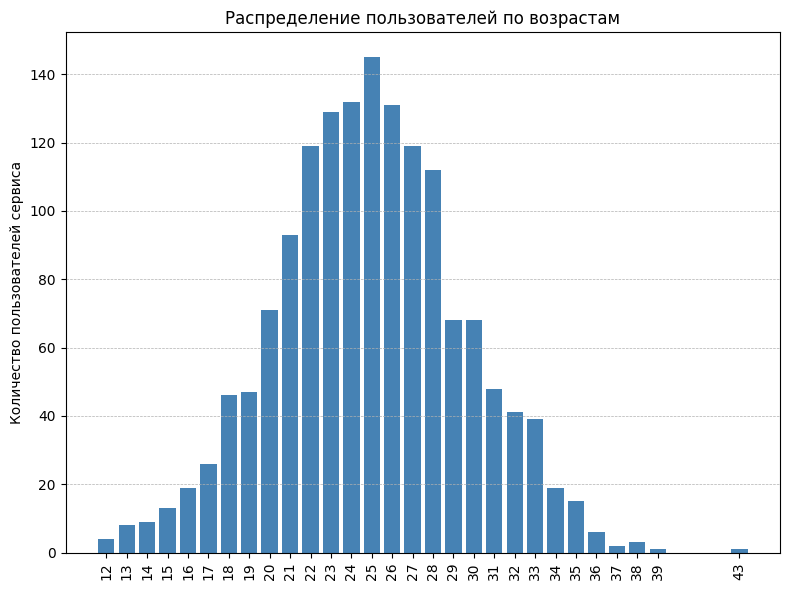

In [16]:
# Создаем столбчатую диаграмму
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Получаем текущие оси

# Группируем данные по возрасту и считаем количество пользователей для каждого возраста
age_counts = users.groupby('age')['user_id'].count().sort_index()

# Строим столбчатую диаграмму
bars = ax.bar(age_counts.index, 
              age_counts.values, 
              color='steelblue')

ax.set_ylabel('Количество пользователей сервиса')
ax.set_title('Распределение пользователей по возрастам')
ax.set_xticks(age_counts.index)
ax.set_xticklabels(age_counts.index, rotation=90)
ax.grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Показываем график
plt.tight_layout()
plt.show()

Как видно из диаграммы наибольшее количество пользователей проката - люди в возрасте от 22 до 28 лет. Минимальный возраст пользователя - 12, максимальный - 43. 

### Расстояние, которое пользователь преодолевает за одну поезду

Выведем общие данные о расстоянии, которое пользователь преодолевает за одну поездку и визуализируем весь массив этих данных путем построения гистограммы.

In [17]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

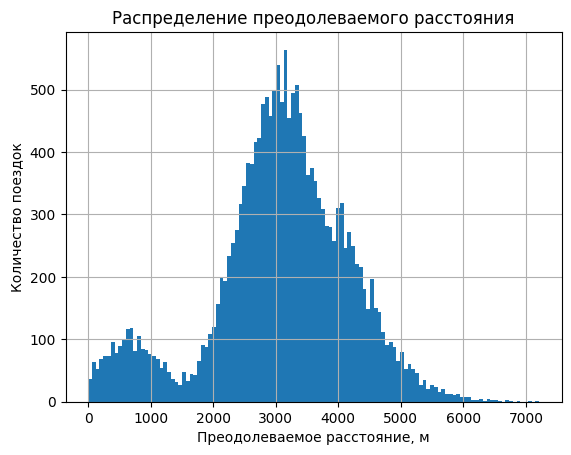

In [18]:
rides['distance'].hist(bins = 120).set(title='Распределение преодолеваемого расстояния', 
                                       xlabel = 'Преодолеваемое расстояние, м', 
                                       ylabel = 'Количество поездок');

Поездки деляться на две неравные группы: 

- на небольшие расстояния (например, чтобы доехать до метро или другого вида общественного транспорта), пиковое расстояние - около 750 метров;
- на большие расстояния (для поездок по городу) с пиковым значением - 3000 метров. 

### Продолжительность поездок

Выведем и визуализируем общие данные о продолжительности поездок.

In [19]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

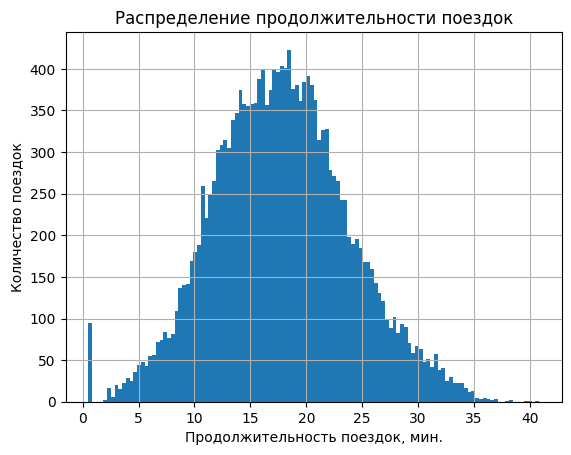

In [20]:
rides['duration'].hist(bins = 120).set(title='Распределение продолжительности поездок', 
                                       xlabel = 'Продолжительность поездок, мин.', 
                                       ylabel = 'Количество поездок');

У большинства пользователей продолжитель поездки составляет от 12 до 22 минут, однако на диаграмме виден значительный всплекс значений около 0. Определим размер и количество таких значений:

In [21]:
# Выведем значения поездок продолжительностью менее 2 минут
short_rides = rides.loc[rides['duration'] < 2]

short_rides_st = f'''
<div style="max-height:200px; overflow:auto;">
    {short_rides.to_html(index=False)}
</div>
'''

display(HTML(short_rides_st))

user_id,distance,duration,date,month
701,4196.445201,0.5,2021-08-31,8
704,4830.824371,0.5,2021-10-14,10
712,4684.004397,0.5,2021-03-04,3
713,5215.642710,0.5,2021-02-25,2
718,5197.436649,0.5,2021-02-11,2
724,6225.520342,0.5,2021-12-16,12
726,4452.491518,0.5,2021-03-01,3
735,4406.954812,0.5,2021-04-13,4
745,5286.167732,0.5,2021-08-17,8
760,4881.391865,0.5,2021-08-29,8


In [22]:
# Выведем количество сверхкоротких поездок
len(rides.loc[rides['duration'] < 2])

95

В 95 случаях пользователи брали самокат на полминуты, при этом расстояние, которое они преодолели за это время - от 4 до 7 км.
Можно предположить, что произошел сбой при заполнени данных о продолжительности поездок.
Заменим значения продолжительности поездок в 0,5 минуты на медианное значение в зависимости от пройденного расстояния.
Добавим в датафрейм `rides` столбец с обозначением категории в зависимости от пройденного расстояния:

In [23]:
def distance(length):
    try:
        if 0 <= length <= 1000:
            return 'Under 1 km'
        elif 1000 <= length <= 2000:
            return 'Under 2 km'
        elif 2000 <= length <= 3000:
            return 'Under 3 km'
        elif 3000 <= length <= 4000:
            return 'Under 4 km'
        elif 4000 <= length <= 5000:
            return 'Under 5 km'
        elif 5000 <= length <= 6000:
            return 'Under 6 km'
        elif 6000 <= length <= 7000:
            return 'Under 7 km'
        elif length >= 7000:
            return 'Under 8 km'
    except:
        pass

rides['distance_category'] = rides['distance'].apply(distance)

In [24]:
# Выведем первые 5 строк для проверки
rides.head(5)

,user_id,distance,duration,date,month,distance_category
0,1,4409.919140,25.599769,2021-01-01,1,Under 5 km
1,1,2617.592153,15.816871,2021-01-18,1,Under 3 km
2,1,754.159807,6.232113,2021-04-20,4,Under 1 km
3,1,2694.783254,18.511000,2021-08-11,8,Under 3 km
4,1,4028.687306,26.265803,2021-08-28,8,Under 5 km


Заменим значение в 0.5 минуты в столбце `duration` на медианное значение в зависимости от категории пройденного расстояния:

In [25]:
for t in rides['distance_category'].unique():
    rides.loc[(rides['distance_category'] == t) & (rides['duration'] == 0.5), 'duration'] = \
    rides.loc[(rides['distance_category'] == t), 'duration'].median()

Заново построим гистограмму:

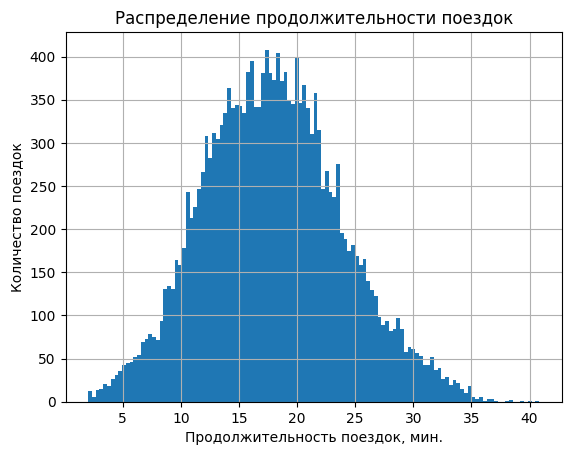

In [26]:
rides['duration'].hist(bins = 120).set(title='Распределение продолжительности поездок', 
                                       xlabel = 'Продолжительность поездок, мин.', 
                                       ylabel = 'Количество поездок');

Основные данные не сильно изменились, наиболее часто встречающаяся продолжительность поездок составиляет от 12 до 22 минут.
Минимальная продолжительность поездки составляет около 2 минут, максимальная - около 42 минут. При этом пик ошибочных значений около 0 устранен. 

## Объединение данных

Объединение данные о пользователях, поездках и подписках в один датафрейм с помощью метода merge().

In [27]:
data = rides.merge(users, 
                   on='user_id', 
                   how='left').merge(subscriptions, 
                                     on='subscription_type', 
                                     how='left')
data.head(5)

,user_id,distance,duration,date,month,distance_category,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Under 5 km,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Under 3 km,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Under 1 km,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Under 3 km,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Under 5 km,0,Кира,22,Тюмень,ultra,6,0,199


Самый длинный исходный датафрейм `rides` содержал 18086 строк, проверим, что количество строк в объединенном датафрейме совпадает с этим значением:

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   distance_category  18068 non-null  object        
 6   index              18068 non-null  int64         
 7   name               18068 non-null  object        
 8   age                18068 non-null  int64         
 9   city               18068 non-null  object        
 10  subscription_type  18068 non-null  object        
 11  minute_price       18068 non-null  int64         
 12  start_ride_price   18068 non-null  int64         
 13  subscription_fee   18068 non-null  int64         
dtypes: dat

Объединенный датафрейм `data` содержит все необходимые на данном этапе анализа столбцы и строки, пропущенные значения отсутствуют.

## Сравнение пользователей с подпиской и без

Визуализируем данные о **расстоянии, которое проезжают пользователи с подпиской и без**, путем построения гистограммы:

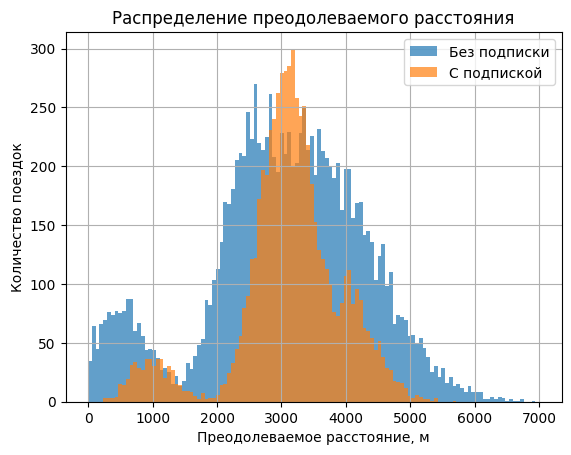

In [29]:
# Построение гистограммы для пользователем без подписки
ax = data.loc[data['subscription_type'] == 'free']['distance'].plot(
    kind='hist',
    range=(0, 7000),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='Без подписки',
    legend=True,
)

# Построение гистограммы для пользователем с подпиской
data.loc[data['subscription_type'] == 'ultra']['distance'].plot(
    kind='hist',
    range=(0, 7000),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='С подпиской',
    ax=ax,
    grid=True,
    legend=True, 
); 

# Добавление заголовка и подписей осей
ax.set(title='Распределение преодолеваемого расстояния', 
       xlabel = 'Преодолеваемое расстояние, м', 
       ylabel = 'Количество поездок');

Хотя количество пользователей с подпиской и без сопоставимо (699 и 835 соответственно), пользователи без подписки значительно чаще пользуются услугами сервиса. 

Пользователи без подписки наиболее часто проезжают расстояние от 2,2 до 4 км (на диаграмме отражено в виде плато).

Пользователи с подпиской чаще проезжают 3 км (на диаграмме отражено резким пиком). 

Визуализируем данные о **продолжительности поездок пользователей с подпиской и без**, путем построения гистограммы:

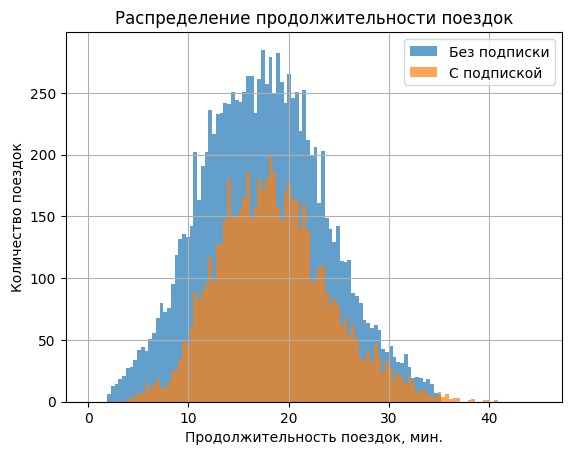

In [30]:
# Построение гистограммы для пользователем без подписки
ax = data.loc[data['subscription_type'] == 'free']['duration'].plot(
    kind='hist',
    range=(0, 45),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='Без подписки',
    legend=True,
)

# Построение гистограммы для пользователем с подпиской
data.loc[data['subscription_type'] == 'ultra']['duration'].plot(
    kind='hist',
    range=(0, 45),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='С подпиской',
    ax=ax,
    grid=True,
    legend=True,
); 

# Добавление заголовка и подписей осей
ax.set(title='Распределение продолжительности поездок', 
       xlabel = 'Продолжительность поездок, мин.', 
       ylabel = 'Количество поездок');

Гистограммы пользователей с подпиской и без практически совпадают по форме, то есть распределение значений в них схоже. Различие обусловлено только разным количеством данных: количество поездок пользователей без подписки сильно больше. Для тех и других самое распространенное время проката самоката от 12 до 22 минут.

## Расчет помесячной выручки

**Создадим датафрейм с агрегированными данными о поездках:**
найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [31]:
# Предварительно округлим продолжительность каждой поездки с помощью метода `np.ceil()`:
data['duration'] = np.ceil(data['duration']) 

In [32]:
data_pivot = data.pivot_table(index=['user_id', 'month'],
                              values=['distance', 'duration'],
                              aggfunc={'distance': 'sum', 'duration': 'sum', 'month': 'count'})

data_pivot = data_pivot.rename(columns={'month': 'rides'})
data_pivot = data_pivot.reset_index()
data_pivot.head(10)

,user_id,month,distance,duration,rides
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
5,1,12,6751.629942,28.0,2
6,2,3,10187.723006,63.0,3
7,2,4,6164.381824,40.0,2
8,2,6,3255.338202,14.0,1
9,2,7,6780.722964,48.0,2


**Добавим в получившийся датафрейм столбец с помесячной выручкой, которую принёс каждый пользователь.**

Создадим промежуточный датафрейм `df1`, в котором содержится информация о типе и стоимости подписки для каждого пользователя:

In [33]:
df1 = data.loc[:, ['user_id', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1.head(5)

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,ultra,6,0,199
1,2,ultra,6,0,199
2,3,ultra,6,0,199
3,4,ultra,6,0,199
4,5,ultra,6,0,199


Присоединим данные из промежуточного датафрейма `df1` к `pivot_table`:

In [34]:
data_pivot = data_pivot.merge(df1, on=['user_id'], how='right')
data_pivot.head(10)

,user_id,month,distance,duration,rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,6,0,199
1,1,4,754.159807,7.0,1,ultra,6,0,199
2,1,8,6723.470560,46.0,2,ultra,6,0,199
3,1,10,5809.911100,32.0,2,ultra,6,0,199
4,1,11,7003.499363,56.0,3,ultra,6,0,199
5,1,12,6751.629942,28.0,2,ultra,6,0,199
6,2,3,10187.723006,63.0,3,ultra,6,0,199
7,2,4,6164.381824,40.0,2,ultra,6,0,199
8,2,6,3255.338202,14.0,1,ultra,6,0,199
9,2,7,6780.722964,48.0,2,ultra,6,0,199


Рассчитаем помесячнную выручку для каждого пользователя в датафрейме `data_pivot`:

In [35]:
data_pivot['monthly_revenue'] = data_pivot['minute_price'] * data_pivot['duration'] +\
                                data_pivot['subscription_fee'] + \
                                data_pivot['start_ride_price'] * data_pivot['rides']
data_pivot.head(10)

,user_id,month,distance,duration,rides,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,4,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,8,6723.470560,46.0,2,ultra,6,0,199,475.0
3,1,10,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,11,7003.499363,56.0,3,ultra,6,0,199,535.0
5,1,12,6751.629942,28.0,2,ultra,6,0,199,367.0
6,2,3,10187.723006,63.0,3,ultra,6,0,199,577.0
7,2,4,6164.381824,40.0,2,ultra,6,0,199,439.0
8,2,6,3255.338202,14.0,1,ultra,6,0,199,283.0
9,2,7,6780.722964,48.0,2,ultra,6,0,199,487.0


## Проверка гипотез

### Гипотеза 1: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Определим среднее значение продолжительности поездок для пользователей с подпиской:

In [36]:
(data.loc[data['subscription_type'] == 'ultra']['duration'].mean()).round(2)

19.04

Определим среднее значение продолжительности поездок для пользователей без подписки:

In [37]:
(data.loc[data['subscription_type'] == 'free']['duration'].mean()).round(2)

18.07

В среднем пользователи с подпиской тратят на поездку примерно на 1 минуту больше, чем пользователи без подписки.

Дополнительно для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем метод scipy.stats.ttest_ind(array1, array2, equal_var, alternative).

**Нулевая гипотеза:** Пользователи с подпиской в среднем тратят столько же времени на поездки, сколько пользователи без подписки.

**Альтернативная гипотеза:** Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [38]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data.loc[data['subscription_type'] == 'ultra']['duration'], 
                       data.loc[data['subscription_type'] == 'free']['duration'], 
                       equal_var = False, 
                       alternative ='greater')

print()
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем  нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу') 
print()


p-значение: 3.572796306092548e-27
Отвергаем  нулевую гипотезу



Поскольку нулевая гипотеза отвергнута, можно сделать вывод о том, что с большей вероятностью **пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки**.

### Гипотеза 2: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (оптимальное расстояние с точки зрения износа самоката).

Посмотрим на среднее расстояние поездки для пользователей с подпиской:

In [39]:
(data.loc[data['subscription_type'] == 'ultra']['distance'].mean()).round(2)

3115.45

Пользователи с подпиской в среднем проезжают чуть более 3115 метров, что меньше порогового значения в 3130 метров.

Дополнительно проверим одностороннюю гипотезу о равенстве среднего генеральной совокупности некоторому значению путем  метода scipy.stats.ttest_1samp().

**Нулевая гипотеза:** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров.

**Алтернативная гипотеза:** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, менее 3130 метров.

In [40]:
interested_value = 3120 # оптимальное для одной поездки расстояние с точки зрения износа самоката

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(data.loc[data['subscription_type'] == 'ultra']['distance'], 
                         interested_value,
                         alternative='less') 

print()
print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()


p-значение: 0.3304213962773028
Не получилось отвергнуть нулевую гипотезу



Среднее и пороговое значения очень близки друг к другу, поэтому **с вероятностью 33% среднее значение, проезжаемое пользователем с подпиской, будет равно 3130**.

### Гипотеза 3: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Рассчитаем среднюю помесячную выручку от пользователей с подпиской:

In [41]:
(data_pivot.loc[data_pivot['subscription_type'] == 'ultra']['monthly_revenue'].mean()).round(2)

362.79

Рассчитаем среднюю помесячную выручку от пользователей без подписки:

In [42]:
(data_pivot.loc[data_pivot['subscription_type'] == 'free']['monthly_revenue'].mean()).round(2)

331.1

Пользователи с подпиской приносят в среднем на 33% выручки больше, чем пользователи без подписки.

Дополнительно для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем метод scipy.stats.ttest_ind(array1, array2, equal_var, alternative).

**Нулевая гипотеза:** Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

**Альтернативная гипотеза:** Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [43]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_pivot.loc[data['subscription_type'] == 'ultra']['monthly_revenue'], 
                       data_pivot.loc[data['subscription_type'] == 'free']['monthly_revenue'], 
                       equal_var=False, 
                       alternative = 'greater')

print()
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print()


p-значение: 8.600900964398781e-14
Отвергаем нулевую гипотезу



Вероятно **выручка, приносимая пользователями с подпиской, не равна выручке, приносимой пользователями без подписки**. Следовательно альтернативная гипотеза не может быть отвергнута. 

В целом можно сказать, что результаты проверки гипотез методами scipy.stats.ttest_ind и scipy.stats.ttest_1samp() соответстуют реальным средним значениям датафреймов за исключением случая, когда среднее и пороговое значение крайне близки. 

По результатам проведенной проверки гипотез не были опровергнуты следующие альтернативные гипотезы:
- пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки;
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
Однако не была опровергнута нулевая гипотеза для следующей альтернативной:
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

## Распределения

### Определение минимального количества рассылок

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

Выше описана ситуация, представляющая из себя биноминальное распределение. 

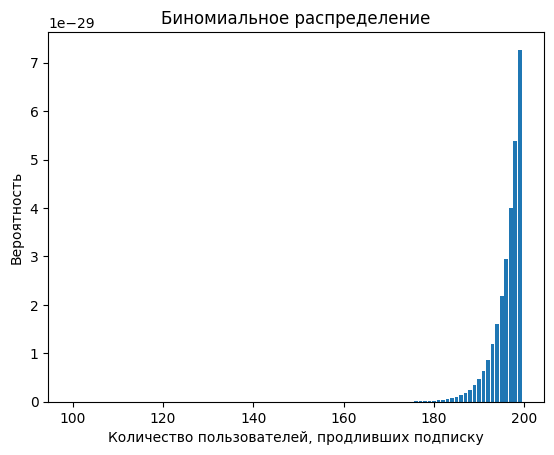


Минимальное количество промокодов: 1061



In [44]:
# Зададим параметры распределения
p = 0.1  # Вероятность успеха (пользователь продлит подписку)
k = 100  # Минимальное количество успехов
alpha = 0.05  # Уровень значимости

# Находим минимальное количество промокодов, используя обратное биномиальное распределение
n = st.nbinom.ppf(1 - alpha, k, p)

# Генерируем данные для графика
x = range(k, k + 100)
y = [st.nbinom.pmf(i, k, p) for i in x]

# Строим график распределения
plt.bar(x, y)
plt.xlabel('Количество пользователей, продливших подписку')
plt.ylabel('Вероятность')
plt.title('Биномиальное распределение')
plt.show();

print()
print(f"Минимальное количество промокодов: {int(n)}")
print()

Можно сделать вывод о том, что 1061 - минимальное количество промокодов, которое необходимо разослать, чтобы с вероятностью около 95% 100 существующих клиентов продлили подписку. 

### Определение вероятности открытия уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации необходимо построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Для аппроксимации биномиального распределения используем нормальное распределение с параметрами, вычисленными на основе биномиального распределения. Параметры нормального распределения определяются следующим образом:

Математическое ожидание = n⋅p

Стандартное отклонение = n⋅p⋅(1−p)

где:

n - количество уведомлений (1 млн),
p - вероятность открытия уведомления (40% или 0.4).

Используем нормальную аппроксимацию и функцию распределения (cdf) для оценки вероятности:

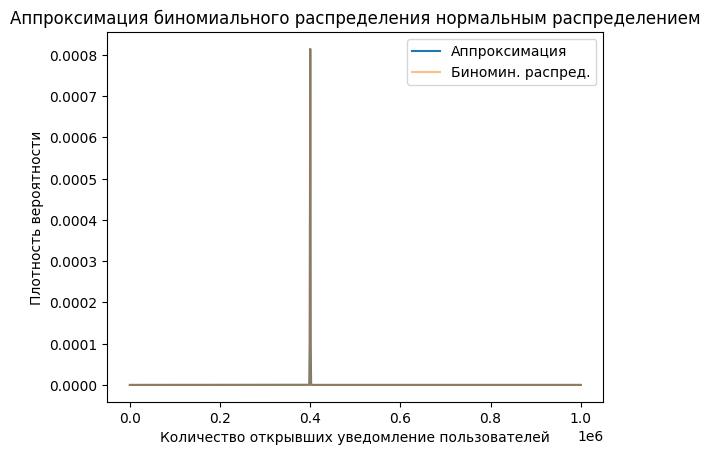


Вероятность, что уведомление откроют не более 399,5 тыс. пользователей: 0.1537


In [45]:
# Параметры распределения
n = 1000000 # Количество предполагаемых к рассылке уведомлений
p = 0.4 # Вероятность открытия уведомлений

# Параметры нормального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Генерируем данные для графика
x = np.arange(0, n + 1, 1000)
y = st.norm.pdf(x, mu, sigma)

# Строим график аппроксимации биномиального распределения
plt.plot(x, y, label='Аппроксимация')

# Строим график биномиального распределения (для сравнения)
binomial_x = np.arange(0, n + 1)
binomial_y = st.binom.pmf(binomial_x, n, p)
plt.plot(binomial_x, binomial_y, label='Биномин. распред.', alpha=0.5)

plt.xlabel('Количество открывших уведомление пользователей')
plt.ylabel('Плотность вероятности')
plt.title('Аппроксимация биномиального распределения нормальным распределением')
plt.legend()
plt.show()
print()

# Оценка вероятности открытия не более 399,5 тыс. пользователей
probability_less_than_399_5k = st.norm.cdf(399500, mu, sigma)
print(f"Вероятность, что уведомление откроют не более 399,5 тыс. пользователей: {probability_less_than_399_5k:.4f}")

Можно сделать вывод о том, что при условии рассылки 1 млн уведомлений вероятность того, что данные уведомления откроют не более 399,5 тыс. пользователей составляет 15,37%.

## Общий вывод

В целом можно сказать, что представленные для анализа данные – полные и релевантные, неявные дубликаты отсутствуют, небольшое количество явных дубликатов было устранено.

Представленные данные одинаково репрезентативны для всех 8 городов, где действует сервис. Самое большое количество пользователей в Пятигорске, самое маленькое – в Москве. 

Количество пользователей без подписки превышает количество пользователей с подпиской на 19% (835 против 699).

Наиболее часто встречающийся возраст пользователей лежит в диапазоне от 22 до 28 лет.

Диаграмма распределения преодолеваемого расстояния показала наличие двух неравных групп, отражающих стратегии пользователей: использование самокатов на малых расстояниях (пиковое значение – 750 метров), использование на больших расстояниях (пиковое значение – 3000 метров). Данные могут быть в дальнейшем использованы для корректировки тарифных планов.

Наиболее частая продолжительность поездок составляет от 12 до 22 минут. 

Выявлен всплеск значений продолжительности поездок, равной 0.5 минуты, при значительном расстоянии поездок. Он характерен только для пользователей без подписки. По всей видимости, речь идет о технической неисправности в работе приложения, поэтому данные были заменены на медианные значения. 

При сопоставимости значений пользователей с подпиской и без, пользователи без подписки совершают практически вдвое больше поездок, чем пользователи с подпиской. 

С наибольшей долей вероятности, пользователи с подпиской потратят больше времени на поездки, чем пользователи без подписки, а также принесут большую выручку. С вероятностью 33% среднее значение, проезжаемое пользователем с подпиской, будет равно 3130 метрам.

Для привлечения с вероятностью в 95% каждых дополнительных 100 пользователей с подпиской необходимо производить рассылку не менее 1061 промокода на один бесплатный месяц подписки в рамках акции. 

При этом при рассылке 1 млн push-уведомлений в мобильном приложении уведомление откроют не более 399,5 тыс. пользователей с вероятностью 15,37%.
